<a href="https://colab.research.google.com/github/Amana28/Deep-Learning/blob/master/Amana_AIT_09_Author_classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [196]:
import numpy as np
from keras.utils import np_utils
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import collections
from collections import Counter
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout


## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [197]:
with open('Pride and Prejudice.txt', 'r') as file:
    austin_text = file.read()

with open('The Great Gatsby.txt', 'r') as file:
    fitzgerald_text = file.read()

# Tokenize the texts
nltk.download('punkt')
austin_tokens = word_tokenize(austin_text)
fitzgerald_tokens = word_tokenize(fitzgerald_text)

# clean the text (Pride and Prejudice)
nltk.download('stopwords')
austin_clean_tokens = []
for token in austin_tokens:
    token = token.lower()  # convert to lowercase
    token = re.sub(r'[^\w\s]', '', token)  # remove punctuation
    if token not in stopwords.words('english'):  # remove stop words
        austin_clean_tokens.append(token)

# clean the text (The Great Gatsby)
fitzgerald_clean_tokens = []
for token in fitzgerald_tokens:
    token = token.lower()  # convert to lowercase
    token = re.sub(r'[^\w\s]', '', token)  # remove punctuation
    if token not in stopwords.words('english'):  # remove stop words
        fitzgerald_clean_tokens.append(token)


# remove empty characters
austin_clean_tokens = list(filter(None, austin_clean_tokens))
fitzgerald_clean_tokens = list(filter(None, fitzgerald_clean_tokens))



# Count the frequency of words
austin_word_freq = collections.Counter(austin_clean_tokens)
fitzgerald_word_freq = collections.Counter(fitzgerald_clean_tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

In [199]:
# Initialize an empty counter object to map character frequencies
austin_char_freq = collections.Counter()
fitzgerald_char_freq = collections.Counter()

# Iterate over the words in the counter object (Jane Austin)
for word, freq in austin_word_freq.items():
    # Iterate over the characters in the word
    for char in word:
        # Add the character frequency to the new counter object
        austin_char_freq[char] += freq

# Iterate over the words in the counter object (Scott Fitzgerald)
for word, freq in fitzgerald_word_freq.items():
    # Iterate over the characters in the word
    for char in word:
        # Add the character frequency to the new counter object
        fitzgerald_char_freq[char] += freq

# Sort the frequency objects by their keys
austin_sorted = collections.OrderedDict(sorted(austin_char_freq.items()))
fitzgerald_sorted = collections.OrderedDict(sorted(fitzgerald_char_freq.items()))

#### Plotting Character frequency for - Jane Austin: Pride and Prejudice

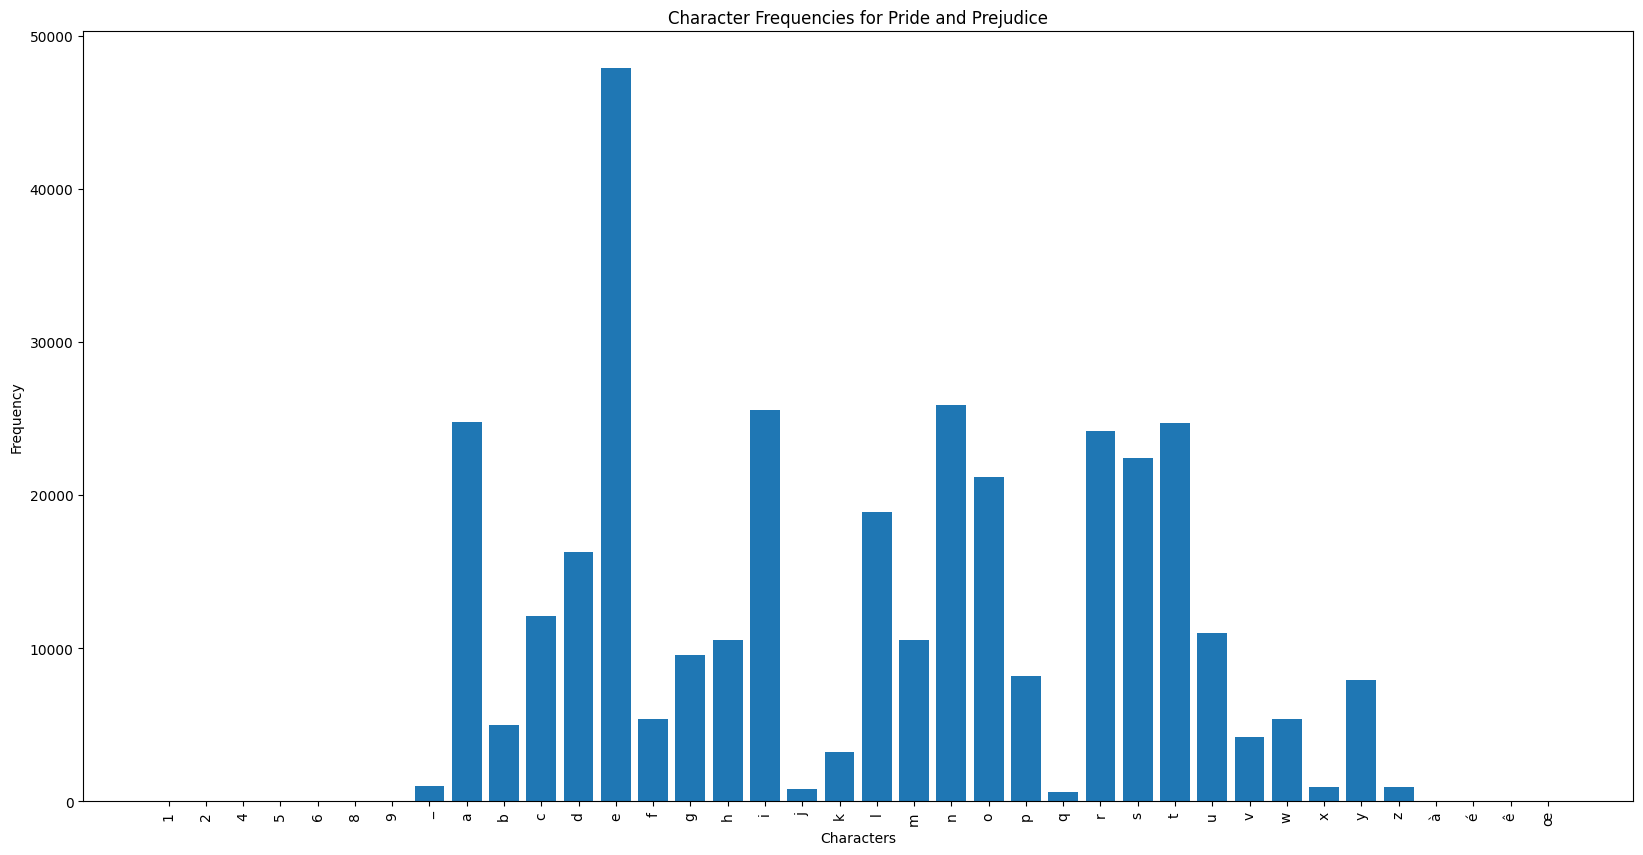

In [200]:
# extract the items and their frequencies as separate lists
items = list(austin_sorted.keys())
freqs = list(austin_sorted.values())

# create a bar plot
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(items, freqs)

# set plot title and labels
ax.set_title('Character Frequencies for Pride and Prejudice')
ax.set_xlabel('Characters')
ax.set_ylabel('Frequency')

# rotate x-axis labels for better readability
plt.xticks(rotation=90)

# show the plot
plt.show()

#### Plotting Character frequency for - Scott Fitzgerald: The Great Gatsby

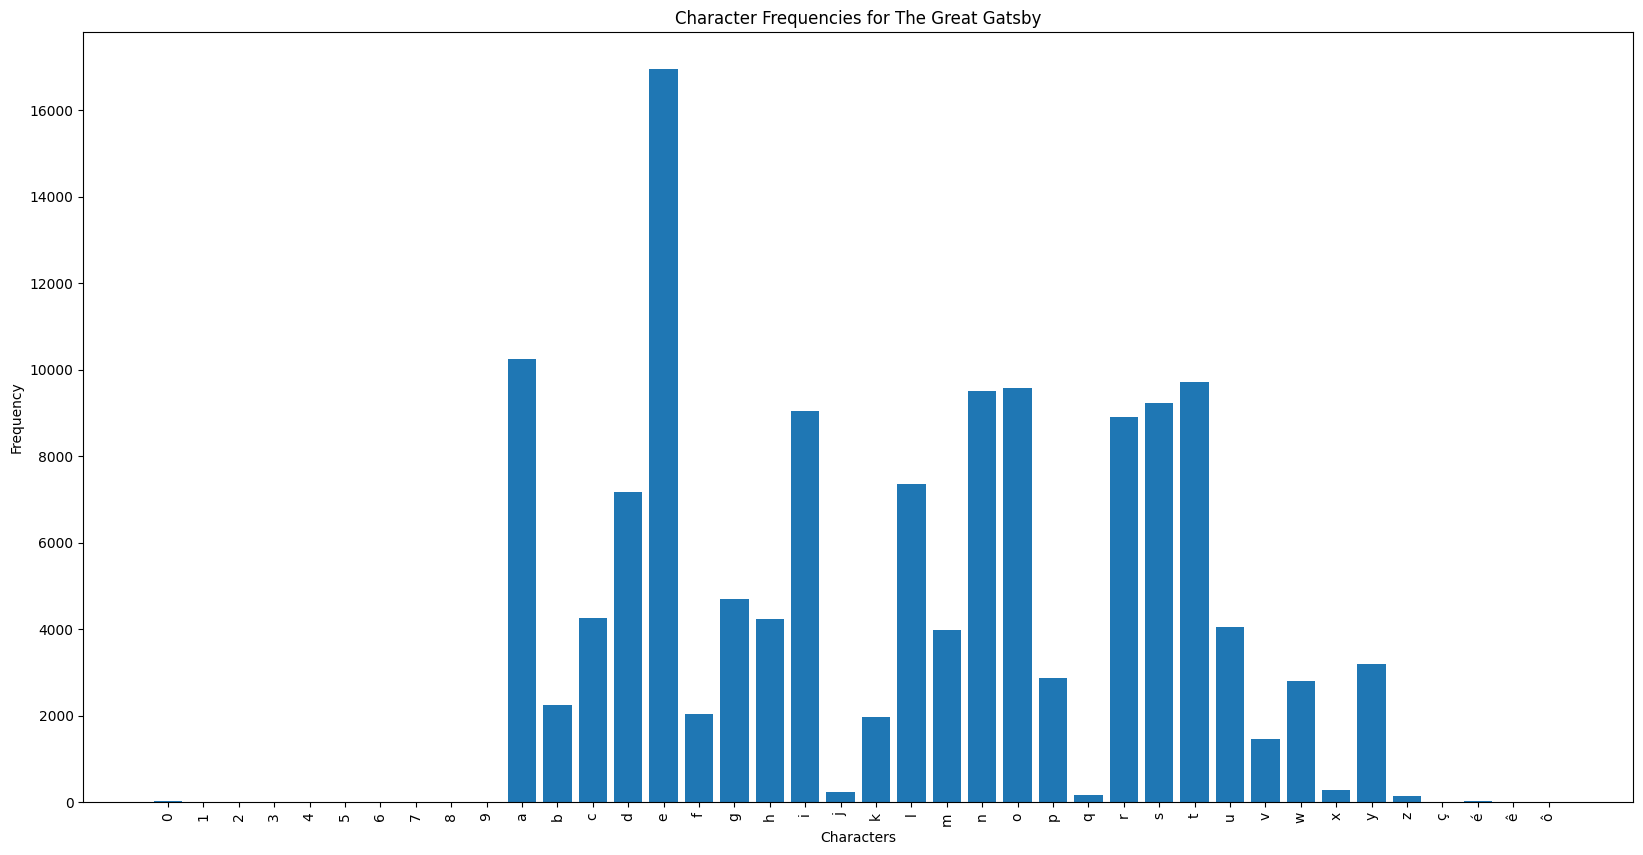

In [201]:
# extract the items and their frequencies as separate lists
items = list(fitzgerald_sorted.keys())
freqs = list(fitzgerald_sorted.values())

# create a bar plot
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(items, freqs)

# set plot title and labels
ax.set_title('Character Frequencies for The Great Gatsby')
ax.set_xlabel('Characters')
ax.set_ylabel('Frequency')

# rotate x-axis labels for better readability
plt.xticks(rotation=90)

# show the plot
plt.show()

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [202]:
# Creating one-hot encodings

# Combine the two lists of tokens into one list
tokens = austin_clean_tokens + fitzgerald_clean_tokens

# Create a Counter object to count the frequency of each character
char_freq = Counter("".join(tokens))

# Get the unique characters and their number
unique_chars = list(char_freq.keys())
num_unique_chars = len(unique_chars)

# Create a dictionary to map each character to its one-hot encoding
char_to_onehot = {}
for i, char in enumerate(unique_chars):
    onehot = np.zeros((num_unique_chars,), dtype=int)
    onehot[i] = 1
    char_to_onehot[char] = onehot

In [203]:
# Define the desired shape of the 3D NumPy array
batch_size = 10
window_size = 2
sequence_length = 60
alphabet_length = len(char_to_onehot)


# PRIDE AND PREJUDICE
# Create an empty 3D NumPy array with the desired shape 
austin_num_sequences = int((len(austin_clean_tokens) - sequence_length + 1)/window_size)
austin_sequences = np.zeros((austin_num_sequences, sequence_length, alphabet_length))



# Create one big string from our token list
austin_concatenated = concatenated = ''.join(austin_clean_tokens)



# Loop over the tokens and their one hot encodings
for i in range(0, austin_num_sequences, window_size):
    token_onehot = []
    # Get the one hot encoding for each character in the sequence
    for j in range(sequence_length):
      curr_char = austin_concatenated[i+j]
      token_onehot += [char_to_onehot[curr_char]]
    index_a = int(i/window_size)
    austin_sequences[index_a, :, :] = np.array(token_onehot) #add to sequence list


# THE GREAT GATSBY
# Create an empty 3D NumPy array with the desired shape 
fitzgerald_num_sequences = int((len(fitzgerald_clean_tokens) - sequence_length + 1)/window_size)
fitzgerald_sequences = np.zeros((fitzgerald_num_sequences, sequence_length, alphabet_length))


# Create one big string from our token list
fitzgerald_concatenated = concatenated = ''.join(austin_clean_tokens)



# Loop over the tokens and their one hot encodings
for i in range(0, fitzgerald_num_sequences, window_size):
    token_onehot = []
    # Get the one hot encoding for each character in the sequence
    for j in range(sequence_length):
      curr_char = austin_concatenated[i+j]
      token_onehot += [char_to_onehot[curr_char]]
    index_f = int(i/window_size)
    fitzgerald_sequences[index_f, :, :] = np.array(token_onehot) #add to sequence list

In [204]:
print(austin_sequences.shape)
print(fitzgerald_sequences.shape)

(27808, 60, 43)
(11657, 60, 43)


In [205]:
# Convert to Austin data to having around the same data points 
reduced_size = int(austin_sequences.shape[0]*0.4)
austin_sequences = austin_sequences[:reduced_size] 

In [206]:
print(austin_sequences.shape)
print(fitzgerald_sequences.shape)

(11123, 60, 43)
(11657, 60, 43)


In [207]:
# Creating labels for our data 
austin_labels = np.zeros((austin_sequences.shape[0], 1))
fitzgerald_labels = np.ones((fitzgerald_num_sequences, 1))

## Data splitting
Split the data into train, validate and test sets. 

In [208]:
# Define the train, validation, and test split sizes as percentages
train_size = 0.6
val_size = 0.2
test_size = 0.2

# Splitting Pride and Prejudice sequences into train, validate and test sets. 

# Get the total number of examples in the list of sequences
austin_total_examples = austin_sequences.shape[0]

# Calculate the number of examples for each split
austin_train_examples = int(train_size * austin_total_examples)
austin_val_examples = int(val_size * austin_total_examples)
austin_test_examples = austin_total_examples - austin_train_examples - austin_val_examples

# Split the sequence into train, validation, and test sets
austin_train_sequence = austin_sequences[:austin_train_examples]
austin_train_labels = austin_labels[:austin_train_examples]
austin_val_sequence = austin_sequences[austin_train_examples:austin_train_examples+austin_val_examples]
austin_val_labels = austin_labels[austin_train_examples:austin_train_examples+austin_val_examples]
austin_test_sequence = austin_sequences[austin_train_examples+austin_val_examples:]
austin_test_labels = austin_labels[austin_train_examples+austin_val_examples:]

# Print the shapes of the train, validation, and test sets
print('PRIDE AND PREJUDICE')
print('Train sequence shape:', austin_train_sequence.shape)
print('Validation sequence shape:', austin_val_sequence.shape)
print('Test sequence shape:', austin_test_sequence.shape)

PRIDE AND PREJUDICE
Train sequence shape: (6673, 60, 43)
Validation sequence shape: (2224, 60, 43)
Test sequence shape: (2226, 60, 43)


In [209]:
# Splitting The Great Gatsby sequences into train, validate and test sets. 


# Get the total number of examples in the list of sequences
fitzgerald_total_examples = fitzgerald_sequences.shape[0]

# Calculate the number of examples for each split
fitzgerald_train_examples = int(train_size * fitzgerald_total_examples)
fitzgerald_val_examples = int(val_size * fitzgerald_total_examples)
fitzgerald_test_examples = fitzgerald_total_examples - fitzgerald_train_examples - fitzgerald_val_examples

# Split the sequence into train, validation, and test sets
fitzgerald_train_sequence = fitzgerald_sequences[:fitzgerald_train_examples]
fitzgerald_train_labels = fitzgerald_labels[:fitzgerald_train_examples]
fitzgerald_val_sequence = fitzgerald_sequences[fitzgerald_train_examples:fitzgerald_train_examples+fitzgerald_val_examples]
fitzgerald_val_labels = fitzgerald_labels[fitzgerald_train_examples:fitzgerald_train_examples+fitzgerald_val_examples]
fitzgerald_test_sequence = fitzgerald_sequences[fitzgerald_train_examples+fitzgerald_val_examples:]
fitzgerald_test_labels = fitzgerald_labels[fitzgerald_train_examples+fitzgerald_val_examples:]

# Print the shapes of the train, validation, and test sets
print('THE GREAT GATSBY')
print('Train sequence shape:', fitzgerald_train_sequence.shape)
print('Validation sequence shape:', fitzgerald_val_sequence.shape)
print('Test sequence shape:', fitzgerald_test_sequence.shape)

THE GREAT GATSBY
Train sequence shape: (6994, 60, 43)
Validation sequence shape: (2331, 60, 43)
Test sequence shape: (2332, 60, 43)


In [210]:
# Concatenating our train, valid and test sets from both authors 

combined_train_sequence = np.concatenate((austin_train_sequence, fitzgerald_train_sequence), axis=0)
combined_train_labels = np.concatenate((austin_train_labels, fitzgerald_train_labels), axis=0)

combined_val_sequence = np.concatenate((austin_val_sequence, fitzgerald_val_sequence), axis=0)
combined_val_labels = np.concatenate((austin_val_labels, fitzgerald_val_labels), axis=0)

combined_test_sequence = np.concatenate((austin_test_sequence, fitzgerald_test_sequence), axis=0)
combined_test_labels = np.concatenate((austin_test_labels, fitzgerald_test_labels), axis=0)

# Print the shapes of the combined train, validation, and test sets
print('Combined Train sequence shape:', combined_train_sequence.shape)
print('Combined Validation sequence shape:', combined_val_sequence.shape)
print('Combined Test sequence shape:', combined_test_sequence.shape)

Combined Train sequence shape: (13667, 60, 43)
Combined Validation sequence shape: (4555, 60, 43)
Combined Test sequence shape: (4558, 60, 43)


## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [211]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, alphabet_length)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [212]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 128)               88064     
                                                                 
 dropout_44 (Dropout)        (None, 128)               0         
                                                                 
 dense_32 (Dense)            (None, 1)                 129       
                                                                 
Total params: 88,193
Trainable params: 88,193
Non-trainable params: 0
_________________________________________________________________
None


## Model training
Train the model and apply early stopping.

In [213]:
es = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(combined_train_sequence, combined_train_labels, epochs=100, batch_size=32, validation_data=(combined_val_sequence, combined_val_labels), callbacks=[es])


Epoch 1/100
428/428 [==============================] - 43s 95ms/step - loss: 0.6425 - accuracy: 0.5643 - val_loss: 0.3004 - val_accuracy: 1.0000
Epoch 2/100
428/428 [==============================] - 40s 94ms/step - loss: 0.6331 - accuracy: 0.5726 - val_loss: 0.3117 - val_accuracy: 0.9998
Epoch 3/100
428/428 [==============================] - 39s 90ms/step - loss: 0.6330 - accuracy: 0.5716 - val_loss: 0.3020 - val_accuracy: 1.0000
Epoch 4/100
428/428 [==============================] - 39s 90ms/step - loss: 0.6329 - accuracy: 0.5714 - val_loss: 0.3062 - val_accuracy: 1.0000


## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [214]:
test_loss, test_acc = model.evaluate(combined_test_sequence, combined_test_labels)

143/143 [==============================] - 5s 33ms/step - loss: 0.2997 - accuracy: 1.0000


In [215]:
print("Test Loss: " + str(test_loss))
print("Test Accuracy: " + str(test_acc))

Test Loss: 0.29968810081481934
Test Accuracy: 1.0


## Confusion matrix
Calculate and display the confusion matrix.

143/143 [==============================] - 8s 57ms/step


<Axes: >

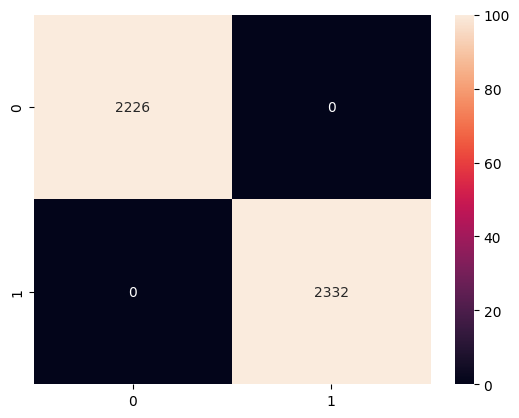

In [217]:
# Calculate and display the confusion matrix
test_predictions = model.predict(combined_test_sequence).round()
cm = confusion_matrix(combined_test_labels, test_predictions)
sns.heatmap(cm, annot=True, fmt='d', vmax=100)

In [218]:
# Finally it works!!